In [1]:
!pip install catboost
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(2434) # Seed 고정

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
data = pd.read_csv('/content/drive/MyDrive/DACON/UndockableLigands/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/DACON/UndockableLigands/test.csv')

In [49]:
data

,ID,RBF,DBF,DACC,DRMSD,DDG_G,DDG_P,BM_feature,PS_PSL_feature,ring_R,...,RAT,dring,dHP,dlogP,ddonor,dPP1,dPP2,dDA,dAT,POS/NEG
0,TRAIN_0000,5.383872,304.0860,585.454,1.077630,-11.1400,14.3822,2,3,17,...,1.000000,17,-2.674000,-19.7661,-4,7.564829,10,-4,0,1
1,TRAIN_0001,9.171635,187.8234,583.326,0.286700,-35.7719,2.6892,11,11,8,...,3.000000,4,-1.844667,-16.3766,4,12.876900,9,4,16,0
2,TRAIN_0002,6.768328,217.0991,540.672,0.497321,-41.3555,-0.7923,13,8,0,...,3.000000,-5,-1.785571,-14.3608,6,7.666167,14,6,14,0
3,TRAIN_0003,9.876999,143.0555,574.080,0.794488,-44.4737,-12.5893,11,9,2,...,13.000000,-1,-1.433143,-9.7490,8,12.018675,7,8,24,1
4,TRAIN_0004,9.445251,206.2381,485.928,0.294693,-33.0467,6.4053,12,8,0,...,3.000000,-6,0.721696,-2.5360,15,12.942300,11,15,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6948,TRAIN_6948,8.520576,527.3601,881.206,1.947550,-38.6951,6.9046,11,9,51,...,6.142857,45,-1.169600,0.3479,-10,23.023608,6,-10,36,1
6949,TRAIN_6949,2.989295,158.0771,612.475,0.252917,-55.1110,4.1868,19,6,4,...,11.000000,-3,0.481333,-14.8839,-4,13.395400,17,-4,30,0
6950,TRAIN_6950,8.712973,135.0048,442.913,0.730032,-3.2407,1.5859,8,4,8,...,6.000000,8,-2.530057,-2.0401,-10,16.419818,0,-10,10,1
6951,TRAIN_6951,13.019309,246.9992,579.413,0.742620,-48.5151,5.0665,7,5,3,...,2.000000,0,0.370000,-2.8817,6,14.256775,9,6,10,0


In [50]:
#data dependant upon other data
#RO5  = RO1 + RO2 + RO3 + RO4

#RPP1 = AA hydrophobicity / logP
#DPP1 = AA hydrophobicity - logP

#RPP2 = CC count / (ON + NO + OO + NN count)
#DPP2 = CC count - (ON + NO + OO + NN count)

#RDA = donor_R / donor_L
#dDA = donor_R - donor_L(some outliers)
#ddonor = donor_R - donor_L
#※donor_R and donor_L already exists

#RAT = count of atom type[1,5,6] / count of atom type[2,3,4]
#DAT = count of atom type[1,5,6] - count of atom type[2,3,4]

#dring = ring_R - ring_L
#※ring_R and ring_L already exists

#dHP - 'hydrophobicity_R' - 'hydrophobicity_L' ※These two already exists

#dlogP = logP_R - logP_R※These two already exists

#donor_R = acceptor_L, donor_L = acceptor_R

data.columns

Index(['ID', 'RBF', 'DBF', 'DACC', 'DRMSD', 'DDG_G', 'DDG_P', 'BM_feature',
       'PS_PSL_feature', 'ring_R', 'ring_L', 'hydrophobicity_R',
       'hydrophobicity_L', 'logP_R', 'logP_L', 'donor_R', 'donor_L',
       'acceptor_R', 'acceptor_L', 'RO1', 'RO2', 'RO3', 'RO4', 'RO5', 'RPP1',
       'RPP2', 'RDA', 'RAT', 'dring', 'dHP', 'dlogP', 'ddonor', 'dPP1', 'dPP2',
       'dDA', 'dAT', 'POS/NEG'],
      dtype='object')

In [65]:
FullTrainData = data.drop(['ID', 'RO5', 'RDA', 'dDA', 'ddonor','dring', 'dHP', 'dlogP', 'acceptor_L', 'acceptor_R', 'POS/NEG'], axis = 1)
FullTrainLabel =data['POS/NEG']

FullTestData = data_test.drop(['ID', 'RO5', 'RDA', 'dDA', 'ddonor','dring', 'dHP', 'acceptor_L', 'acceptor_R', 'dlogP'], axis = 1)

In [64]:
np.unique(FullTrainData.isnull()) #no NaN detected

array([False])

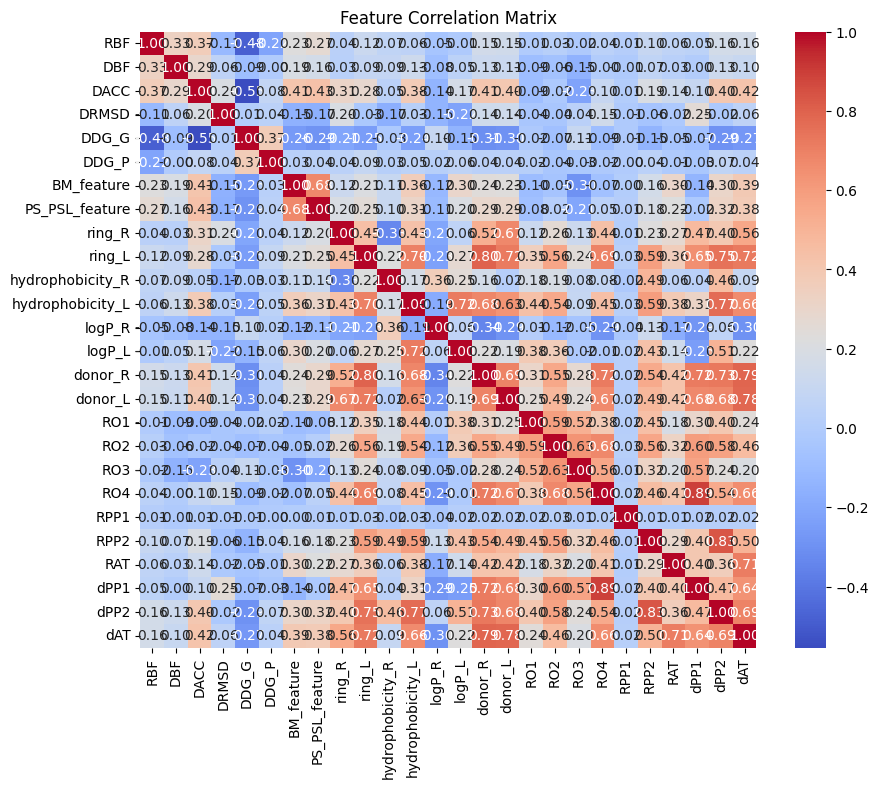

In [54]:
correlation_matrix = FullTrainData.corr()

# Show correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Matrix")
plt.show()

In [55]:
train_data, vald_data, train_label,  vald_label = train_test_split(FullTrainData, FullTrainLabel, test_size = 0.2, random_state = 2434, stratify = FullTrainLabel)

train_data = train_data.to_numpy()
vald_data = vald_data.to_numpy()
train_label = train_label.to_numpy()
vald_label = vald_label.to_numpy()

full_data = FullTrainData.to_numpy()
full_label = FullTrainLabel.to_numpy()

test_data = FullTestData.to_numpy()

print(f"Input shape of the train data : {np.shape(train_data)}, input shape of the train label : {np.shape(train_label)}\nInput shape of the valdition data : {np.shape(vald_data)}, input shape of the vladioaon label : {np.shape(vald_label)}")
print(f"Input shape of the test data : {np.shape(test_data)}")

Input shape of the train data : (5562, 26), input shape of the train label : (5562,)
Input shape of the valdition data : (1391, 26), input shape of the vladioaon label : (1391,)
Input shape of the test data : (2981, 26)


In [ ]:
def ensemble_pred(data_prediction, LGBM, RF, XGB, ADAB, CAT):
  LGBM_proba = LGBM.predict_proba(data_prediction)
  RF_proba = RF.predict_proba(data_prediction)
  XGB_proba = XGB.predict_proba(data_prediction)
  ADAB_proba = ADAB.predict_proba(data_prediction)
  CAT_proba = CAT.predict_proba(data_prediction)
  VotingResult = np.argmax((LGBM_proba+ RF_proba+ XGB_proba+ ADAB_proba+ CAT_proba)/5, axis = 1)

  return VotingResult


In [56]:
def when_the_matrix_is_confused_idk_I_dont_know_data_science(Confusion_Matrix):
  TN = Confusion_Matrix[0][0]
  FN = Confusion_Matrix[0][1]
  FP = Confusion_Matrix[1][0]
  TP = Confusion_Matrix[1][1]

  Sensitivity = TP/(TP + FN)
  Specificity = TN/(TN + FP)

  Precision = TP/(TP + FP)
  Recall = Sensitivity

  F1_Score = 2 * Precision * Recall / (Precision + Recall)
  return Sensitivity, Specificity, Precision, Recall, F1_Score


In [57]:
LR = LogisticRegression()
LR.fit(train_data, train_label)
LR_proba = LR.predict_proba(vald_data)
LR_val = LR.predict(vald_data)

LGBM = LGBMClassifier(n_estimators=100)
LGBM.fit(train_data, train_label)
LGBM_proba = LGBM.predict_proba(vald_data)
LGBM_val = LGBM.predict(vald_data)

RF = RandomForestClassifier(n_estimators = 100)
RF.fit(train_data, train_label)
RF_proba = RF.predict_proba(vald_data)
RF_val = RF.predict(vald_data)

XGB = XGBClassifier(n_estimators = 100)
XGB.fit(train_data, train_label)
XGB_proba = XGB.predict_proba(vald_data)
XGB_val = XGB.predict(vald_data)

ADAB = AdaBoostClassifier(n_estimators = 100)
ADAB.fit(train_data, train_label)
ADAB_proba = ADAB.predict_proba(vald_data)
ADAB_val = ADAB.predict(vald_data)

CAT = CatBoostClassifier(n_estimators = 100)
CAT.fit(train_data, train_label)
CAT_proba = CAT.predict_proba(vald_data)
CAT_val = CAT.predict(vald_data)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2789, number of negative: 2773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3640
[LightGBM] [Info] Number of data points in the train set: 5562, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005753
[LightGBM] [Info] Start training from score 0.005753


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Learning rate set to 0.177071
0:	learn: 0.6511005	total: 6.46ms	remaining: 640ms
1:	learn: 0.6115113	total: 11.8ms	remaining: 577ms
2:	learn: 0.5870719	total: 16.9ms	remaining: 545ms
3:	learn: 0.5679886	total: 22.1ms	remaining: 529ms
4:	learn: 0.5428378	total: 27.4ms	remaining: 521ms
5:	learn: 0.5274019	total: 32.7ms	remaining: 512ms
6:	learn: 0.5164081	total: 37.8ms	remaining: 503ms
7:	learn: 0.5061085	total: 43.1ms	remaining: 496ms
8:	learn: 0.4992473	total: 48.4ms	remaining: 489ms
9:	learn: 0.4906196	total: 53.9ms	remaining: 485ms
10:	learn: 0.4824071	total: 59.3ms	remaining: 480ms
11:	learn: 0.4757190	total: 64.5ms	remaining: 473ms
12:	learn: 0.4700723	total: 69.7ms	remaining: 466ms
13:	learn: 0.4648490	total: 74.8ms	remaining: 460ms
14:	learn: 0.4527637	total: 80.1ms	remaining: 454ms
15:	learn: 0.4471057	total: 85.5ms	remaining: 449ms
16:	learn: 0.4436824	total: 92.4ms	remaining: 451ms
17:	learn: 0.4397267	total: 97.5ms	remaining: 444ms
18:	learn: 0.4352588	total: 103ms	remaining:

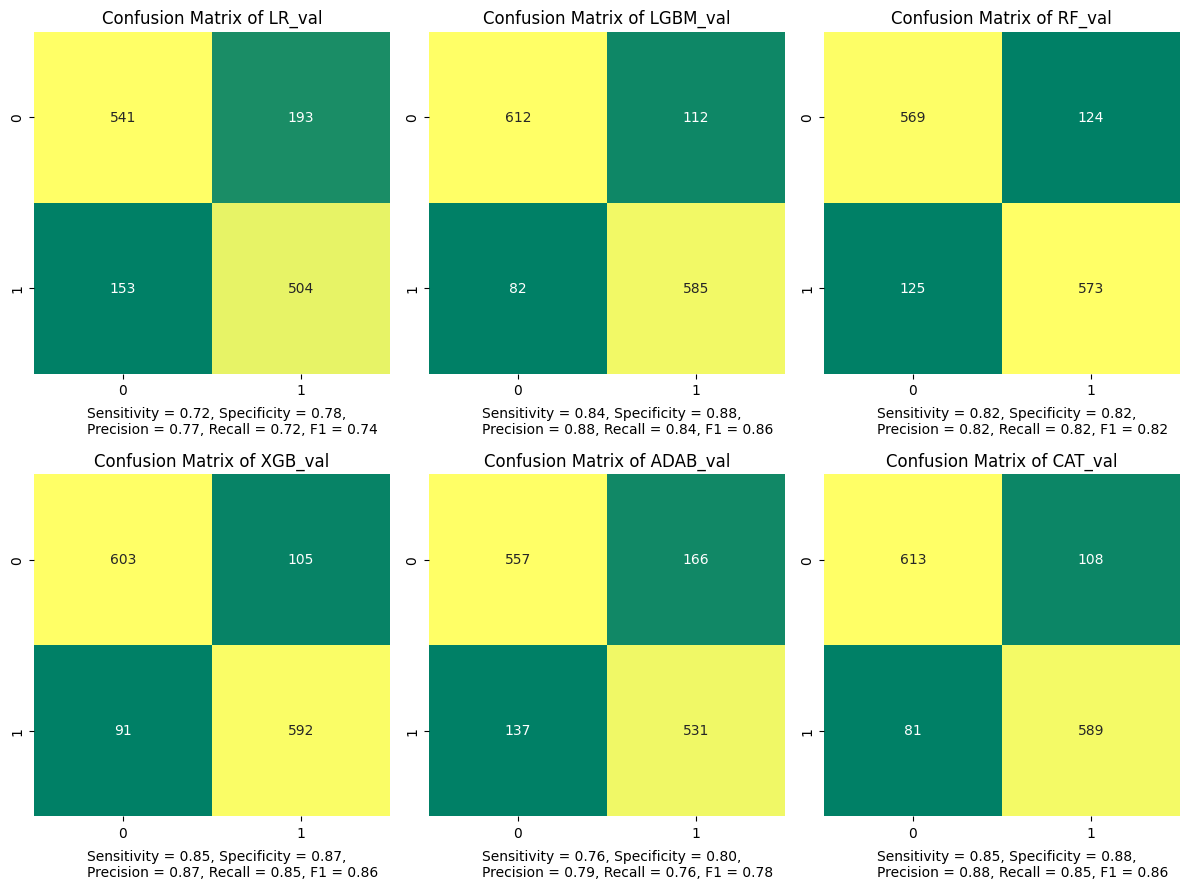

In [58]:
plt.figure(figsize = (12,9))

the_council = [LR_val, LGBM_val, RF_val, XGB_val, ADAB_val, CAT_val]
council_nomen = ['LR_val', 'LGBM_val', 'RF_val', 'XGB_val', 'ADAB_val', 'CAT_val']

for mdl_idx in range(len(council_nomen)):
  Confusion_Matrix = np.zeros((2,2))
  for i in np.arange(len(vald_label)):
    Confusion_Matrix[the_council[mdl_idx][i]][vald_label[i]] += 1

  Sensitivity, Specificity, Precision, Recall, F1_Score  = when_the_matrix_is_confused_idk_I_dont_know_data_science(Confusion_Matrix)
  plt.subplot(2,3,mdl_idx + 1)
  sns.heatmap(Confusion_Matrix.astype("int32"), annot = True, fmt = 'd', cbar = False, cmap = 'summer')

  plt.title("Confusion Matrix of "+council_nomen[mdl_idx])
  plt.text(0.3, 2.35, f"Sensitivity = {Sensitivity:.2f}, Specificity = {Specificity:.2f}, \nPrecision = {Precision:.2f}, Recall = {Recall:.2f}, F1 = {F1_Score:.2f}")
  plt.tight_layout()


In [59]:
#Soft voting because uuuh democracy
VotingResult = np.argmax((LGBM_proba+ RF_proba+ XGB_proba+ ADAB_proba + CAT_proba)/5, axis = 1)

Text(0.3, 2.35, 'Sensitivity = 0.85, Specificity = 0.88, \nPrecision = 0.88, Recall = 0.85, F1 = 0.86')

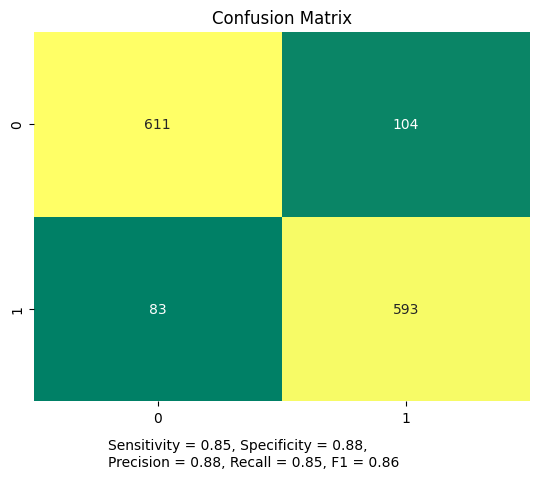

In [60]:
Confusion_Matrix = np.zeros((2,2))
for i in np.arange(len(vald_label)):
  Confusion_Matrix[VotingResult[i]][vald_label[i]] += 1

Sensitivity, Specificity, Precision, Recall, F1_Score  = when_the_matrix_is_confused_idk_I_dont_know_data_science(Confusion_Matrix)
sns.heatmap(Confusion_Matrix.astype("int32"), annot = True, fmt = 'd', cbar = False, cmap = 'summer')

plt.title("Confusion Matrix")
plt.text(0.3, 2.35, f"Sensitivity = {Sensitivity:.2f}, Specificity = {Specificity:.2f}, \nPrecision = {Precision:.2f}, Recall = {Recall:.2f}, F1 = {F1_Score:.2f}")

In [61]:
#Fine Tuning
def fine_tuning(full_data, full_label, test_data, LGBM, RF, XGB, ADAB, CAT):
  LR = LogisticRegression()
  LR.fit(full_data, full_label)
  LR_proba = LR.predict_proba(test_data)

  LGBM = LGBMClassifier(n_estimators=100)
  LGBM.fit(full_data, full_label)
  LGBM_proba = LGBM.predict_proba(test_data)

  RF = RandomForestClassifier(n_estimators = 100)
  RF.fit(full_data, full_label)
  RF_proba = RF.predict_proba(test_data)

  XGB = XGBClassifier(n_estimators = 100)
  XGB.fit(full_data, full_label)
  XGB_proba = XGB.predict_proba(test_data)

  ADAB = AdaBoostClassifier(n_estimators = 100)
  ADAB.fit(full_data, full_label)
  ADAB_proba = ADAB.predict_proba(test_data)

  CAT = CatBoostClassifier(n_estimators = 100)
  CAT.fit(full_data, full_label)
  CAT_proba = CAT.predict_proba(test_data)


  VotingResult = np.argmax((LGBM_proba+ RF_proba+ XGB_proba+ ADAB_proba+CAT_proba)/5, axis = 1)

  return VotingResult

In [62]:
sample_submission = pd.read_csv('/content/drive/MyDrive/DACON/UndockableLigands/sample_submission.csv')
sample_submission['POS/NEG'] = fine_tuning(full_data, full_label, test_data, LGBM, RF, XGB, ADAB, CAT)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3486, number of negative: 3467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3651
[LightGBM] [Info] Number of data points in the train set: 6953, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501366 -> initscore=0.005465
[LightGBM] [Info] Start training from score 0.005465


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Learning rate set to 0.194779
0:	learn: 0.6407750	total: 20.3ms	remaining: 2.01s
1:	learn: 0.6004646	total: 28.6ms	remaining: 1.4s
2:	learn: 0.5743204	total: 43.6ms	remaining: 1.41s
3:	learn: 0.5532474	total: 58.3ms	remaining: 1.4s
4:	learn: 0.5355976	total: 73.6ms	remaining: 1.4s
5:	learn: 0.5236533	total: 114ms	remaining: 1.78s
6:	learn: 0.5124576	total: 142ms	remaining: 1.88s
7:	learn: 0.5015088	total: 160ms	remaining: 1.84s
8:	learn: 0.4931783	total: 176ms	remaining: 1.78s
9:	learn: 0.4860839	total: 196ms	remaining: 1.76s
10:	learn: 0.4804909	total: 208ms	remaining: 1.69s
11:	learn: 0.4754655	total: 229ms	remaining: 1.68s
12:	learn: 0.4700093	total: 247ms	remaining: 1.65s
13:	learn: 0.4637065	total: 268ms	remaining: 1.64s
14:	learn: 0.4525900	total: 292ms	remaining: 1.65s
15:	learn: 0.4488462	total: 312ms	remaining: 1.64s
16:	learn: 0.4433414	total: 335ms	remaining: 1.63s
17:	learn: 0.4389835	total: 349ms	remaining: 1.59s
18:	learn: 0.4144500	total: 367ms	remaining: 1.56s
19:	learn

In [63]:
sample_submission.to_csv("Le_Ensemble_LGBM_RF_XGB_ADAB_CAT_removetth_another_dependency_finetuned.csv", index = False)

#※§☆★+++===== FEATURE DESCRIPTION =====+++★☆§※



##★☆★▷ Pair Feature ◁★☆★

###1 - RBF

Enva에 binding에 관여하는 [ receptor원자들에 대한 B-factor sum ] vs. [ ligand 원자들에 대한 B-factor sum ] 에 대한 ratio

###2 - DBF
Enva에 binding에 관여하는 [ receptor원자들에 대한 B-factor sum ] vs. [ ligand 원자들에 대한 B-factor sum ] 에 대한 difference

###3 - DACC
[ ligand의 pocket안에서의 sum of Water ACC ]  vs, [ ligand의 Vaccum (Openbabel) 에서의 Water ACC ] 의 difference
###4 - DRMSD
[ ligand의 pocke안에서 구조  ] vs. [ pocket 바깥에서의 구조 ] difference
###5 - DDG_G
Delta-Delta Gibbs Free Energy (GBSA(Generalized born surface area)-binding free energy)
###6 - DDG_P
Delta-Delta Gibbs Free Energy  (PBSA(Poisson-Boltzmann surface area)-binding free energy)
##★☆★▷ Word Frequency ◁★☆★
###7 - BM_feat
Top 1600 BM(binding mode) word 보유 수
###8 - PS_PSL_feature
Top 40 PS(pocket shape) word 보유 수, Top 40 PSL(pocket shape ligand)  word 보유 수 중 작은 수

##★☆★▷ Simple Features ◁★☆★

###9 - ring_R
Interaction 기여 residue 의 ring 총합
###10 - ring_L
Ligand 의 ring 개수
###11 - hydro_R
Interaction 기여 residue 의 hydrophobicity평균 (Kyte_Doolittle_scale)
###12 - hydro_L
Ligand 구성 atom의 hydrophobicity 총합(Ghose_Crippen_scale)
###13 - logP_R
Interaction 기여 logP의 총합
###14 - logP_L
ligand의 logP
###15 - donor_R
enva donor/acceptor = 1
###16 - donor_L
enva donor/acceptor = 2
###17 - accep_R
enva donor/acceptor = 2
###18 Accep_L
enva donor/acceptor = 1


##★☆★▷ Lipinski's rule of five ◁★☆★
###19 - RO1
RO1 = 1 if HBD <= 5 else 0
###20 - RO2
RO2 = 1 if HBA <= 10 else 0
###21 - RO3
RO3 = 1 if MW < 500 else 0
###22 - RO4
RO4 = 1 if LogP <= 5 else 0
###23 - RO5
RO5 = RO1 + RO2 + RO3 + RO4

##★☆★▷ Minor Pair Feature ◁★☆★
###24 - RPP1
Ratio of AA hydrophobicity and logP
###25 - RPP2
Ratio of CC count  and (ON + NO + OO + NN count)
###26 - RDA
Ratio of donor_R and donor_L
###27 - RAT
Ratio of count of atom type [1,5,6]  and count of atom type [2,3,4]
###28 - Dring
Ring number difference
###29 - Dhp
hydrophobicity_R –hydrophobicity_L
###30 - Dlogp
logP_R - logP_L
###31 - Ddonor
donor_R - donor_L
###32 - Dpp1
AA hydrophobicity - logP
###33 - Dpp2
CC count – (ON + NO + OO + NN count)
###34 - Dda
donor_R - donor_L
###35 - Dat
count of atom type [1,5,6] – count of atom type [2,3,4]

##★☆★▷ Thing that thou shalt evaluate ◁★☆★
###36 - Pos/neg
Positive or negative data(Positive : 1 , Negative : 0)

###Terms
*Enva: Software for protein engineering

* B-factor : Flexibility of atoms in PDB

* ACC : water accessibility

* RMSD : root mean square deviation

